# Demo code on how to use a pretrained OptFormer model

### Note: to select a target behavior policy to imitate by OptFormer, one should insert the algorithm name to a study's metadata, or set the designer_name argument in OptFormerDesigner.

Valid algorithm names are:
*   Grid Search: 'designer_grid_search'
*   Shuffled Grid Search: 'designer_grid_search_shuffled'
*   Random search: 'designer_random_search'
*   Regularized Evolution: 'designer_reg_evo'
*   Hill-Climbing: 'designer_hill_climb'
*   Eagle Strategy: 'designer_eagle_strategy'
*   Vizier GP-UCB: 'designer_recursive_gp'

In [ ]:
#@title Imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from vizier import algorithms as vza
from vizier import benchmarks
from vizier import pyvizier as vz
from optformer.t5x import inference_utils
from optformer.t5x import policies
from optformer.t5x import utils
from optformer.data import converters

# Fix the "RuntimeError: This event loop is already running" when loading 
# checkpoints in a notebook.
import nest_asyncio
nest_asyncio.apply()

# Set the correct jax backend.
JAX_PLATFORM = 'cpu'  #@param{"type": "string"}
jax.config.update('jax_platforms', JAX_PLATFORM)

In [ ]:
#@title Functions

def run_optimization(experimenter, policy, num_trials):
  """Run optimization for a given number of steps."""
  trials = []
  for _ in range(num_trials):
    print(f'Generating {_+1}/{num_trials} trials.')
    trial = policy.suggest(1)[0].to_trial()
    
    experimenter.evaluate([trial])
    trials.append(trial)

    policy.update(vza.CompletedTrials([trial]))
  return trials

def plot_trials(problem_statement, trials):
  """Collect parameter and function values and plot"""
  xs = []
  param_names = [
      pc.name for pc in problem_statement.search_space.parameters]
  xs = np.array([[trial.parameters[n].value for n in param_names]
                for trial in trials])
  metric_name = problem_statement.metric_information.item().name
  ys = np.array([trial.final_measurement.metrics[metric_name].value
                for trial in trials])

  plt.plot(xs[:, 0], 'o-', label=param_names[0])
  plt.plot(xs[:, 1], 'o-', label=param_names[1])
  plt.legend()
  plt.xlabel('Trial')
  plt.ylabel('Parameter')
  plt.show()

  plt.plot(xs[:, 0], xs[:, 1], 'o-');
  plt.xlabel(param_names[0])
  plt.ylabel(param_names[1])
  plt.show()

  plt.plot(ys, 'o-', label='y')
  plt.legend()
  plt.xlabel('Trial')
  plt.ylabel('Function')
  plt.show()

def int_to_y(i, aux, quant_levels):
  """Convert quantized y value to the original range."""
  assert len(aux['objective_mapping']) == 1
  mapping = next(iter(aux['objective_mapping'].values()))
  offset = mapping['offset']
  scale = mapping['scale']
  return (((np.asarray(i) + 0.5) / quant_levels) - offset) / scale

In [ ]:
#@title Constants

# Model Gin configuration and checkpoint path.
OPTFORMER_DIR = 'add_your_root_directory_of_optformer'  #@param{"type": "string"}
MODEL_GIN_FILE = policies.BBOB_INFERENCE_MODEL_KWARGS['model_gin_file']  #@param{"type": "string"}
CHECKPOINT_PATH = policies.BBOB_INFERENCE_MODEL_KWARGS['checkpoint_path_or_model_dir']  #@param{"type": "string"}

BATCH_SIZE = 1  #@param{"type": "integer"}

ALGORITHM = 'designer_recursive_gp'  #@param{"type": "string"}

In [ ]:
#@title Load a transformer inference model.

inference_model = inference_utils.InferenceModel.from_checkpoint(
    CHECKPOINT_PATH,
    batch_size=BATCH_SIZE,
    model_gin_file=MODEL_GIN_FILE,
    gin_search_paths=[OPTFORMER_DIR],
)
vocab = inference_model.vocab
study_converter = inference_model.study_converter

In [ ]:
#@title Create an example Study for demo.

#@markdown Create an experimenter with a 2D BBOB Rosenbrock Rotated function.
experimenter = benchmarks.NumpyExperimenter(
    benchmarks.bbob.RosenbrockRotated,
    problem_statement=benchmarks.bbob.DefaultBBOBProblemStatement(2))

#@markdown Add 10 random trials.
trials = []
for _ in range(10):
  suggestion = vz.TrialSuggestion()
  for p_config in experimenter.problem_statement().search_space.parameters:
    suggestion.parameters[p_config.name] = np.random.uniform(p_config.bounds[0],
                                                             p_config.bounds[1])
  trial = suggestion.to_trial()
  experimenter.evaluate([trial])
  trials.append(trial)

#@markdown Make a study from the experimenter and trials. Set the algorithm name.
study = converters.Study(problem=experimenter.problem_statement(), trials=trials)
study.problem.metadata[converters.METADATA_ALGORITHM_KEY] = ALGORITHM

# Study tokenization

In [ ]:
#@markdown Inspect the text sequences converted from the study converter.

#@markdown About the metadata in the converted sequence:
#@markdown * The pretrained BBOB model's study convert drops most metadata because the function name, e.g., "ELLIPSOID_SEPARABLE", "STEP_ELLIPSOID", and parameter names, e.g., "x0", "x1", are not useful for transferring to new test functions.
#@markdown * The pretrained HPO-B model always contains the full metadata (search space name, dataset id, hyperparameter names, etc) in order to transfer to the test set of HPO-B tasks.

converted_study = study_converter.study_to_texts(study)

print('#Parameters:', len(study.problem.search_space.parameters))
print('#Trials:', len(study.trials))

print(f'Conditional input sequence converted from the metadata:')
print(converted_study.inputs)
print()

print(f'Target sequence converted from trials:')
print(converted_study.targets)

#Parameters: 2
#Trials: 10
Conditional input sequence converted from the metadata:
N:"",A:"designer_recursive_gp",O:"",G:<2>&&N:"",S:<0>,P:<1>*N:"",S:<0>,P:<1>

Target sequence converted from trials:
<311><701>*<200>|<946><319>*<800>|<558><827>*<206>|<534><538>*<200>|<285><994>*<206>|<368><668>*<202>|<566><967>*<212>|<491><21>*<217>|<833><580>*<359>|<111><942>*<238>


In [ ]:
#@markdown Input token sequences converted from the text sequence, to be fed into the OptFormer model.
dataset = inference_model.get_dataset([study]).as_numpy_iterator()
batch = next(iter(dataset))

print('Batch feature dict:')
for k, v in batch.items():
  print(k, v.dtype, v.shape)

Batch feature dict:
encoder_input_tokens int32 (1, 256)
decoder_target_tokens int32 (1, 2048)
decoder_target_types int32 (1, 2048)
decoder_input_tokens int32 (1, 2048)
decoder_loss_weights int32 (1, 2048)


In [ ]:
#@markdown Decoding the first 10 tokens in 'encoder_input_tokens'
first_tokens = batch['encoder_input_tokens'][0, :10]
print('Few 10 encoder_input_tokens:', first_tokens)
print('Token index: word piece')
for t in first_tokens:
  word_piece = vocab.decode_tf([t]).numpy().decode()
  print(f'{t}:\t{word_piece}')

Few 10 encoder_input_tokens: [ 445   10  121 1686  188   10  121 9124   49  834]
Token index: word piece
445:	N
10:	:
121:	"
1686:	",
188:	A
10:	:
121:	"
9124:	design
49:	er
834:	_


In [ ]:
#@markdown Decoding the first 10 tokens in 'decoder_target_tokens'
first_tokens = batch['decoder_target_tokens'][0, :10]
print('Few 10 decoder_target_tokens:', first_tokens)
for t in batch['decoder_target_tokens'][0, :10]:
  word_piece = vocab.decode_tf([t]).numpy().decode()
  print(f'{t}:\t{word_piece}')

Few 10 decoder_target_tokens: [    3 32411 32801  1935 32300  9175 33046 32419  1935 32900]
3:	
32411:	<311>
32801:	<701>
1935:	*
32300:	<200>
9175:	|
33046:	<946>
32419:	<319>
1935:	*
32900:	<800>


# Model inference

In [ ]:
#@markdown **If the inference_model.compute_logits returns NaN, Uncomment and apply this hack to run inference on CPU. Policy sampling is not affected.**
# inference_model._partitioned_compute_logits_from_batch = jax.jit(
#     inference_model._compute_logits_from_batch, static_argnums=[2], backend='cpu')

In [ ]:
#@title One forward pass of OptFormer to predict the discrete token distribution at every step.
logits, batches, auxs = inference_model.compute_logits([study])
batch = batches[0]
aux = auxs[0]  # Auxiliary information used for study conversion.
print(f'Shape of logits (#studies, max_sequence_length, valid token range(0-999)):', logits.shape)

if jnp.isnan(logits).any():
  raise ValueError('inference_model.compute_logits returns logits with NaN. '
                   'Try applying the following hack to disable accelerator.' )

Shape of logits (#studies, max_sequence_length, valid token range(0-999)): (1, 2048, 1000)


In [ ]:
#@markdown utils.TrialTokenScheme is a utility class to calculate the index of parameter and function tokens.
scheme = utils.TrialTokenScheme(num_initial_tokens=1)
num_parameters = inference_model.num_parameters(aux)

Parameter name: x1


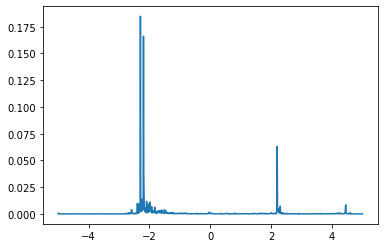

Parameter name: x0


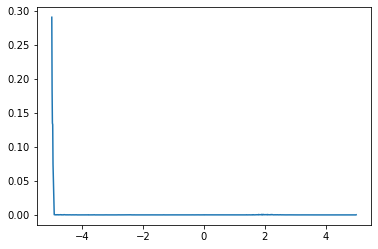

In [ ]:
#@title Distribution of the predicted parameter values in trial 1.

# Parameter order is randomly permuted in every study conversion unless randomize_parameter_order=False is set in the converter.
param_name_order = list(aux['parameter_name_to_configs'].keys())
for p_idx, token_idx in enumerate(scheme.param_index_range_in_trial(
    num_parameters, trial_index=1)):
  p_logits = logits[0, token_idx]
  p_log_probs = inference_utils.logits_to_log_probs(p_logits)
  print(f'Parameter name: {param_name_order[p_idx]}')
  p_config = aux['parameter_name_to_configs'][param_name_order[p_idx]]
  x_range = np.linspace(p_config.bounds[0], p_config.bounds[1], len(p_log_probs))
  plt.plot(x_range, np.exp(p_log_probs))
  plt.show()

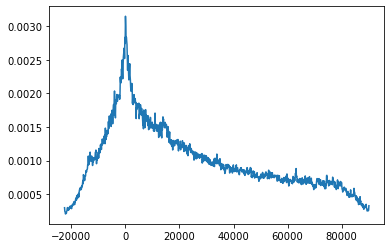

In [ ]:
#@title Distribution of the predicted function value in trial 1

# Parameter order is randomly permuted in every study conversion unless randomize_parameter_order=False is set in the converter.
param_name_order = list(aux['parameter_name_to_configs'].keys())
token_idx = scheme.fun_index_in_trial(num_parameters, trial_index=1)

f_logits = logits[0, token_idx]
f_log_probs = inference_utils.logits_to_log_probs(f_logits)

y_range = int_to_y(np.arange(len(f_log_probs)), aux,
                   study_converter.num_quantized_values)
plt.plot(y_range, np.exp(f_log_probs))
plt.show()

# Run OptFormer as a policy

## Prior policy: Grid Search

In [ ]:
#@markdown Create a policy.
prior_policy = policies.OptFormerDesigner(
    experimenter.problem_statement(),
    inference_model=inference_model,
    designer_name='designer_grid_search',
    policy_type=policies.PolicyType.PRIOR)

In [ ]:
#@markdown Run the optimization for 10 steps.
prior_trials = run_optimization(experimenter, prior_policy, num_trials=10)

Generating 1/10 trials.
Generating 2/10 trials.
Generating 3/10 trials.
Generating 4/10 trials.
Generating 5/10 trials.
Generating 6/10 trials.
Generating 7/10 trials.
Generating 8/10 trials.
Generating 9/10 trials.
Generating 10/10 trials.


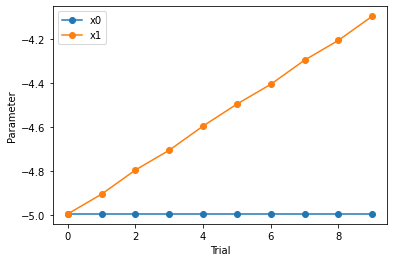

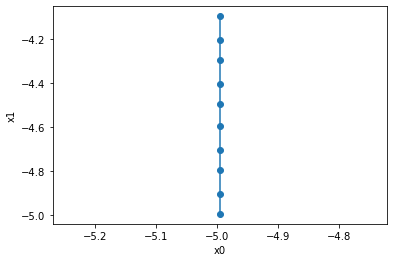

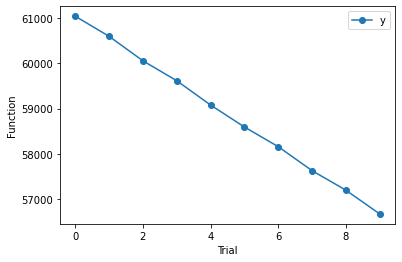

In [ ]:
#@markdown Plotting.
plot_trials(experimenter.problem_statement(), prior_trials)

## Prior policy: Vizier GP-UCB

In [ ]:
#@markdown Create a policy.
prior_policy = policies.OptFormerDesigner(
    experimenter.problem_statement(),
    inference_model=inference_model,
    designer_name='designer_recursive_gp',
    policy_type=policies.PolicyType.PRIOR)

In [ ]:
#@markdown Run the optimization for 10 steps.
prior_trials = run_optimization(experimenter, prior_policy, num_trials=10)

Generating 1/10 trials.
Generating 2/10 trials.
Generating 3/10 trials.
Generating 4/10 trials.
Generating 5/10 trials.
Generating 6/10 trials.
Generating 7/10 trials.
Generating 8/10 trials.
Generating 9/10 trials.
Generating 10/10 trials.


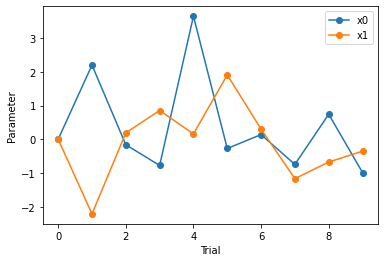

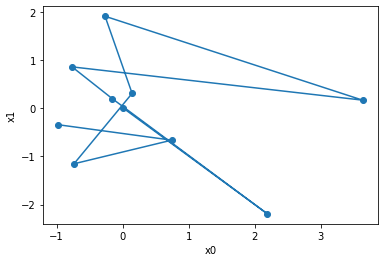

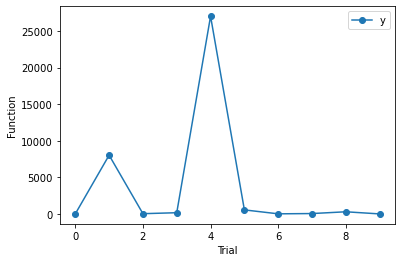

In [ ]:
#@markdown Plotting.
plot_trials(experimenter.problem_statement(), prior_trials)

## Augmented policy with EI

In [ ]:
#@markdown Create a policy.
augmented_policy = policies.OptFormerDesigner(
    experimenter.problem_statement(),
    inference_model=inference_model,
    designer_name='designer_recursive_gp',
    policy_type=policies.PolicyType.RANK_SAMPLES,
    num_samples=64,
    ranking_config={'type': 'ei'})

In [ ]:
#@markdown Run the optimization for 10 steps.
augmented_trials = run_optimization(experimenter, augmented_policy, num_trials=10)

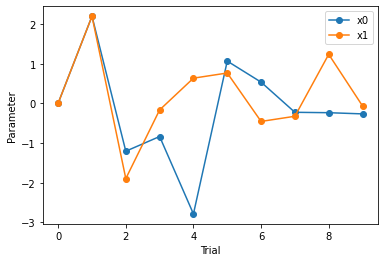

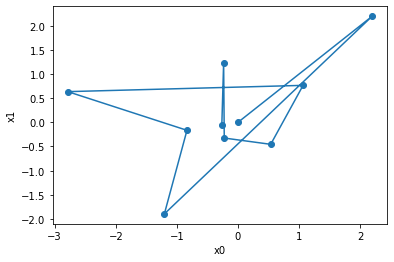

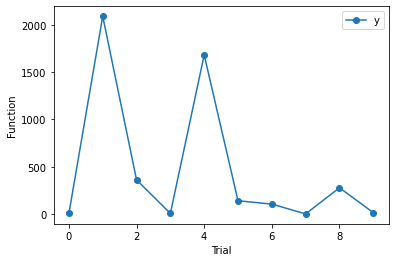

In [ ]:
#@markdown Plotting.
plot_trials(experimenter.problem_statement(), augmented_trials)